<h1 align='center'>Rain Prediction using ANN</h1>
<h1 align='center'>Assignment 2 - Set 7</h1><hr>
<h2>Group - 270<br><br>Rochit Jain - 2020sc04439<br><br>Suraj Jha - 2020sc04853</h2> <hr>

## Importing Libraries

In [1]:
# for data manipulation
import numpy as np 
import pandas as pd 

from sklearn.model_selection import train_test_split # for splitting the data into train and test samples
from sklearn.metrics import classification_report # for model evaluation metrics
from sklearn.preprocessing import LabelEncoder # for encoding categorical features from strings to number arrays
from sklearn.metrics import confusion_matrix # for model confusion matrix
from sklearn.impute import SimpleImputer # for Missing value imputation
from sklearn.decomposition import PCA # for dimensions reduction

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from IPython.display import display # for object display

# for ANN modelling
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

## Defining Utility function

In [2]:
# Function to get categorical column volumetric analysis
def get_volumetric(dataset, col):
    col_volumetric = dataset[col].value_counts(dropna=False).reset_index()
    col_volumetric.columns = [col, 'volume']
    col_volumetric['%volume'] = ((col_volumetric['volume']*100)/col_volumetric['volume'].sum()).round(2)
    return col_volumetric

# Function to check and get the missingValue volumetric analysis
def check_missingValue(dataset):
    null_volumetric = dataset.isnull().sum().reset_index()
    null_volumetric.columns = ['Column', 'Missing value']
    null_volumetric['%Missing value'] = ((null_volumetric['Missing value']*100)/dataset.shape[0]).round(2)
    return null_volumetric

# Function to plot the confusion matrix
def plot_cm(y_true, y_pred, figsize=(8,6)):
    # get the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    
    # plotting the heatmap
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "Blues", annot=annot, fmt='', ax=ax)

## Importing Dataset

### Rain Prediction

- Context:
    - Predict next-day rain by training classification models on the target variable RainTomorrow.


- Content:
    - This dataset contains about 10 years of daily weather observations from many locations across Australia.

    - RainTomorrow is the target variable to predict. It means -- did it rain the next day, Yes or No? This column is Yes if the rain for that day was 1mm or more.

In [3]:
dataset = pd.read_csv("weatherAUS.csv", index_col=False)

print("Dataset Shape:", dataset.shape)

Dataset Shape: (145460, 23)


## Data Visualization and Exploration

Printing the first 5 & last 5 rows for sanity check to identify all the features present in the dataset and if the target matches with them.

In [4]:
# First 5 rows
print("First 5 rows of the dataset")
display(dataset.head(5))

# Last rows
print("Last 5 rows of the dataset")
display(dataset.tail(5))

First 5 rows of the dataset


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


Last 5 rows of the dataset


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No
145459,2017-06-25,Uluru,14.9,NaN,0.0,NaN,NaN,NaN,NaN,ESE,...,62.0,36.0,1020.2,1017.9,8.0,8.0,15.0,20.9,No,NaN


### Univariate & Multivariate Descriptive Analysis

#### Target Column Distribution - RainTomorrow

,RainTomorrow,volume,%volume
0,No,110316,75.84
1,Yes,31877,21.91
2,NaN,3267,2.25


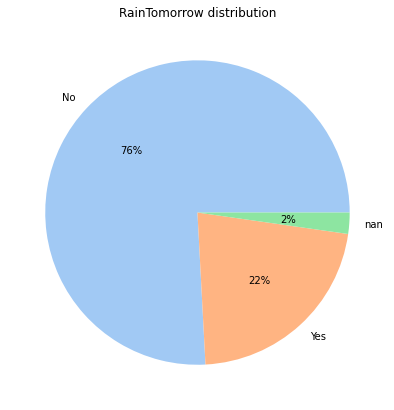

In [5]:
# Getting the RainTomorrow class distribution 
target_volumetric =  get_volumetric(dataset, 'RainTomorrow')
display(target_volumetric)

# Plotting a pie chart
colors = sns.color_palette('pastel')[0:5]
plt.figure(figsize=(7,7))
plt.title("RainTomorrow distribution")
plt.pie(target_volumetric['%volume'], 
        labels = target_volumetric['RainTomorrow'], 
        colors = colors, autopct='%.0f%%')
plt.show();

In [6]:
# Printing a concise summary of a DataFrame.
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [7]:
# Creating column's subsets as per the datatype
dataset_dtypes = dataset.dtypes.reset_index()
dataset_dtypes.columns = ['variable', 'dtype']
# Getting the categorical columns
cat_cols = dataset_dtypes[dataset_dtypes['dtype']=='object']['variable'].tolist()
# Getting the continuos columns
cont_cols = dataset_dtypes[dataset_dtypes['dtype']!='object']['variable'].tolist()

print("Categorical Columns:", cat_cols)
print()
print("Continuos Columns:", cont_cols)

Categorical Columns: ['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']

Continuos Columns: ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']


#### Categorical Columns

In [8]:
# Descriptive statistics include those that summarize the count, unique and top category freq of a dataset’s distribution.
dataset[cat_cols].describe().T

,count,unique,top,freq
Date,145460,3436,2013-11-12,49
Location,145460,49,Canberra,3436
WindGustDir,135134,16,W,9915
WindDir9am,134894,16,N,11758
WindDir3pm,141232,16,SE,10838
RainToday,142199,2,No,110319
RainTomorrow,142193,2,No,110316


In [9]:
# Getting the category volume distribution and cardinality
for col in cat_cols:
    cat_volumteric_t = get_volumetric(dataset, col)
    print(col)
    print(f"Unique Category preset: {cat_volumteric_t.shape[0]}")
    display(cat_volumteric_t)
    print()

Date
Unique Category preset: 3436


,Date,volume,%volume
0,2013-11-12,49,0.03
1,2014-09-01,49,0.03
2,2014-08-23,49,0.03
3,2014-08-24,49,0.03
4,2014-08-25,49,0.03
...,...,...,...
3431,2007-11-29,1,0.00
3432,2007-11-28,1,0.00
3433,2007-11-27,1,0.00
3434,2007-11-26,1,0.00



Location
Unique Category preset: 49


,Location,volume,%volume
0,Canberra,3436,2.36
1,Sydney,3344,2.30
2,Darwin,3193,2.20
3,Melbourne,3193,2.20
4,Brisbane,3193,2.20
5,Adelaide,3193,2.20
6,Perth,3193,2.20
7,Hobart,3193,2.20
8,Albany,3040,2.09
9,MountGambier,3040,2.09



WindGustDir
Unique Category preset: 17


,WindGustDir,volume,%volume
0,NaN,10326,7.10
1,W,9915,6.82
2,SE,9418,6.47
3,N,9313,6.40
4,SSE,9216,6.34
5,E,9181,6.31
6,S,9168,6.30
7,WSW,9069,6.23
8,SW,8967,6.16
9,SSW,8736,6.01



WindDir9am
Unique Category preset: 17


,WindDir9am,volume,%volume
0,N,11758,8.08
1,NaN,10566,7.26
2,SE,9287,6.38
3,E,9176,6.31
4,SSE,9112,6.26
5,NW,8749,6.01
6,S,8659,5.95
7,W,8459,5.82
8,SW,8423,5.79
9,NNE,8129,5.59



WindDir3pm
Unique Category preset: 17


,WindDir3pm,volume,%volume
0,SE,10838,7.45
1,W,10110,6.95
2,S,9926,6.82
3,WSW,9518,6.54
4,SSE,9399,6.46
5,SW,9354,6.43
6,N,8890,6.11
7,WNW,8874,6.10
8,NW,8610,5.92
9,ESE,8505,5.85



RainToday
Unique Category preset: 3


,RainToday,volume,%volume
0,No,110319,75.84
1,Yes,31880,21.92
2,NaN,3261,2.24



RainTomorrow
Unique Category preset: 3


,RainTomorrow,volume,%volume
0,No,110316,75.84
1,Yes,31877,21.91
2,NaN,3267,2.25


### Bi-Variate EDA on Categorical Attributes (Fetaures) w.r.t RainTomorrow

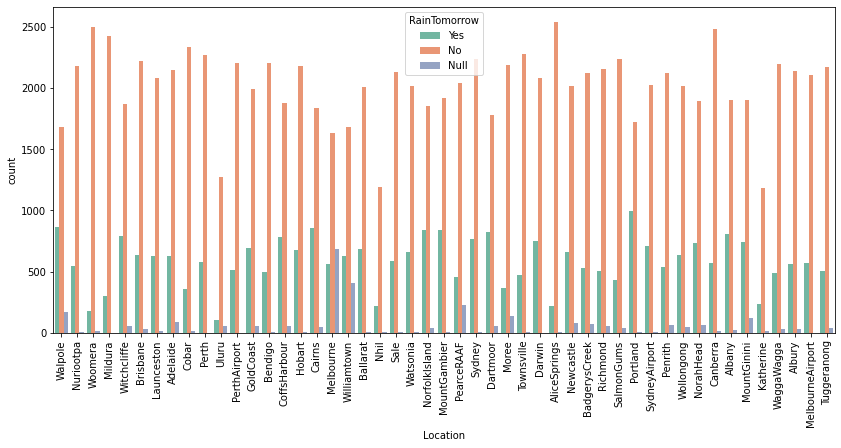

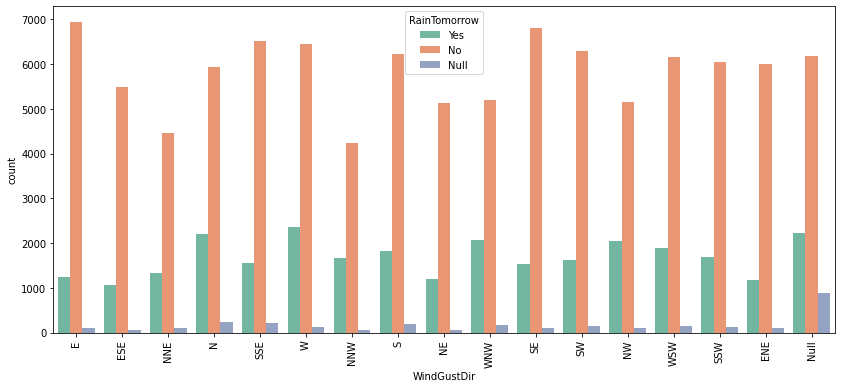

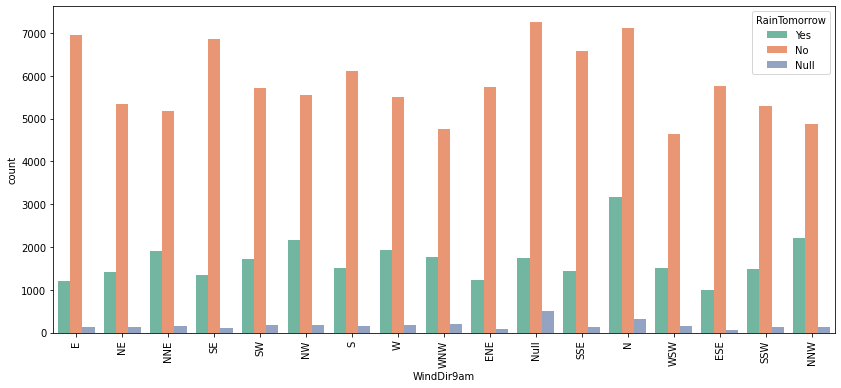

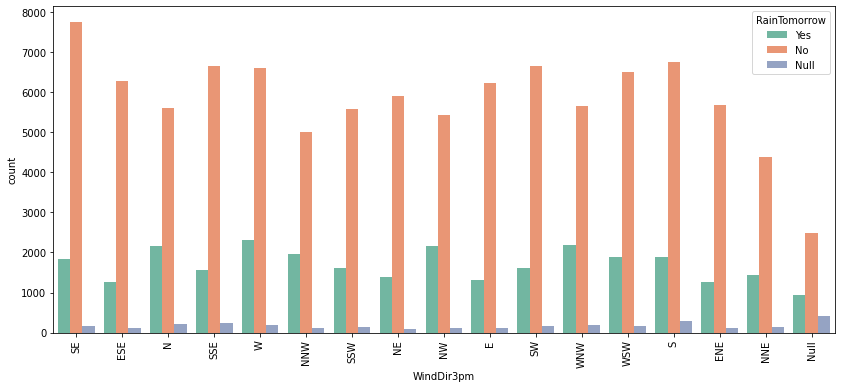

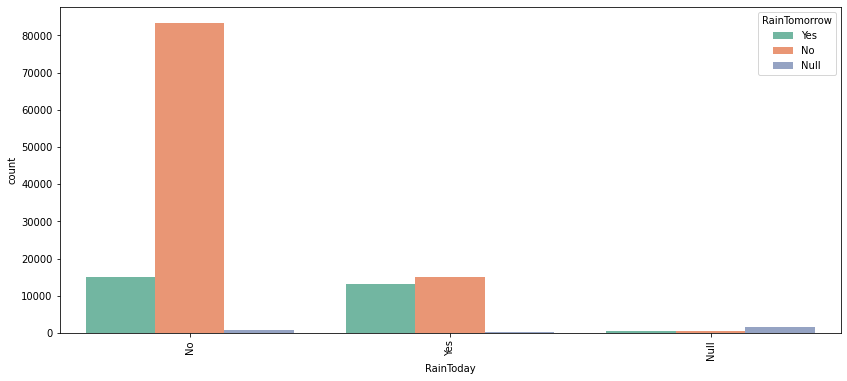

In [10]:
# Cross table plot

ns = int(dataset.shape[0]*.90)
dataset_sample = dataset.sample(n = ns).fillna('Null')

for col in cat_cols:
    if col not in ["RainTomorrow", "Date"]:
        fig = plt.figure(figsize=(14, 6));
        ax = fig.gca();
        ax.tick_params(axis='x', rotation=90)
        sns.countplot(x=col, hue="RainTomorrow", data=dataset_sample, palette="Set2", ax = ax)

#### Continuos Columns

In [11]:
# Descriptive statistics include those that summarize the central tendency, dispersion and shape of a dataset’s distribution.
dataset[cont_cols].describe(percentiles=[.05,.25,.50,.75,.95]).round(2).T

,count,mean,std,min,5%,25%,50%,75%,95%,max
MinTemp,143975.0,12.19,6.40,-8.5,1.8,7.6,12.0,16.9,23.0,33.9
MaxTemp,144199.0,23.22,7.12,-4.8,12.8,17.9,22.6,28.2,35.5,48.1
Rainfall,142199.0,2.36,8.48,0.0,0.0,0.0,0.0,0.8,13.0,371.0
Evaporation,82670.0,5.47,4.19,0.0,1.0,2.6,4.8,7.4,12.0,145.0
Sunshine,75625.0,7.61,3.79,0.0,0.3,4.8,8.4,10.6,12.8,14.5
WindGustSpeed,135197.0,40.04,13.61,6.0,20.0,31.0,39.0,48.0,65.0,135.0
WindSpeed9am,143693.0,14.04,8.92,0.0,0.0,7.0,13.0,19.0,30.0,130.0
WindSpeed3pm,142398.0,18.66,8.81,0.0,6.0,13.0,19.0,24.0,35.0,87.0
Humidity9am,142806.0,68.88,19.03,0.0,34.0,57.0,70.0,83.0,98.0,100.0
Humidity3pm,140953.0,51.54,20.80,0.0,17.0,37.0,52.0,66.0,88.0,100.0


### Bi-Variate EDA on Continuos Attributes (Features) w.r.t to RainTomorrow

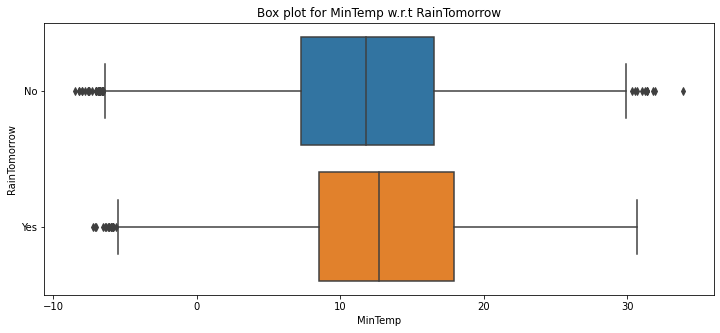

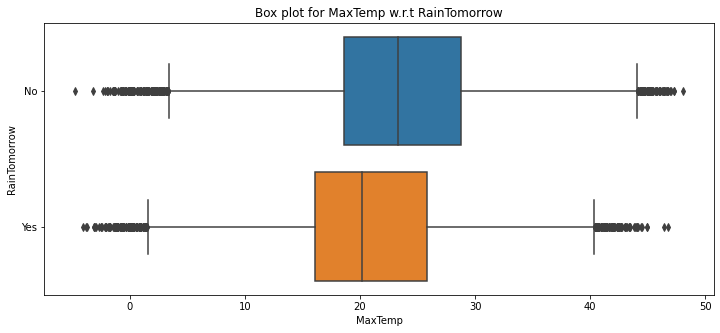

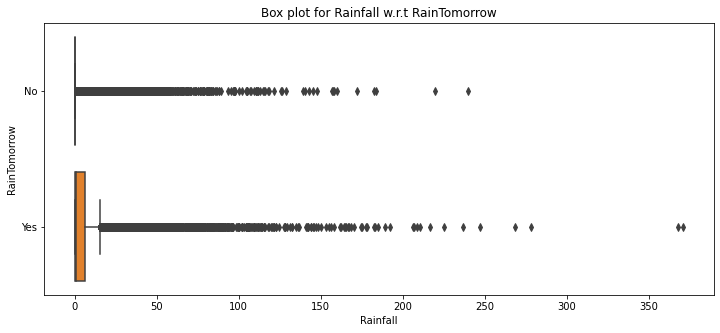

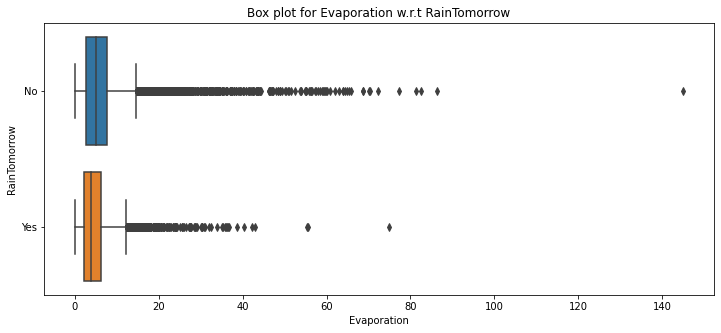

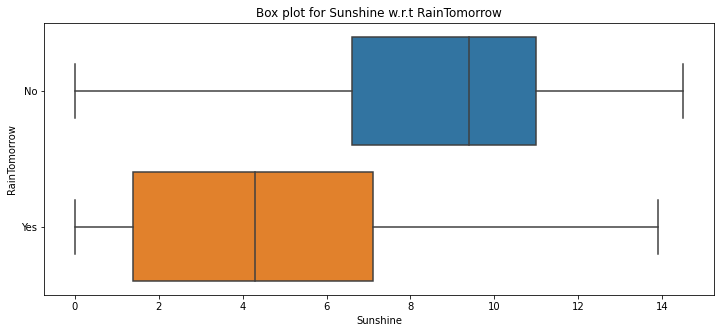

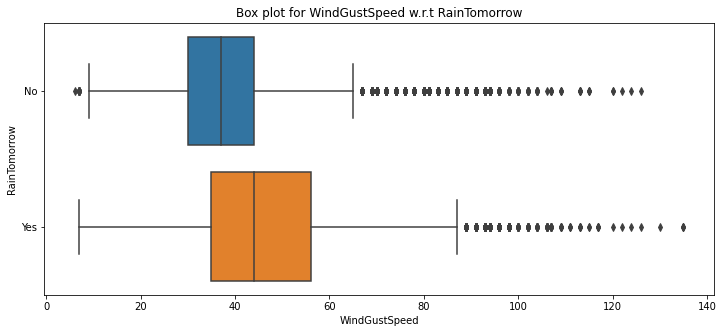

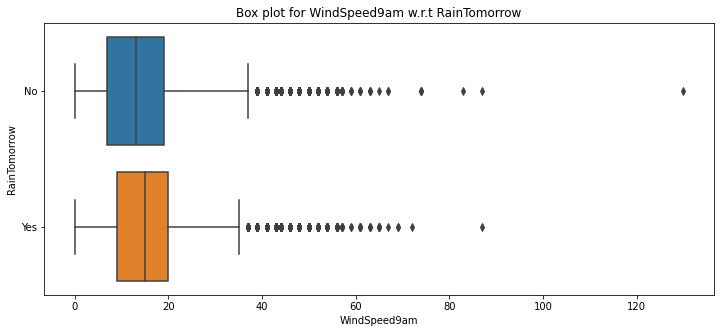

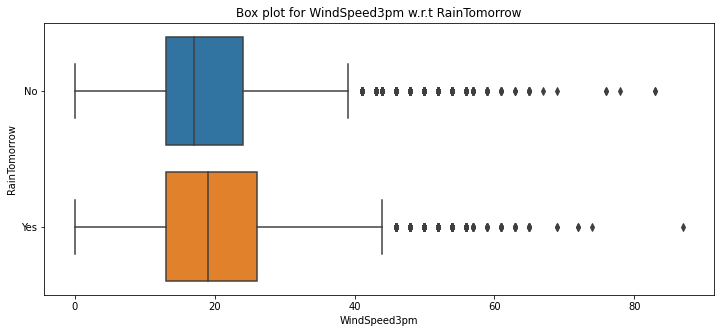

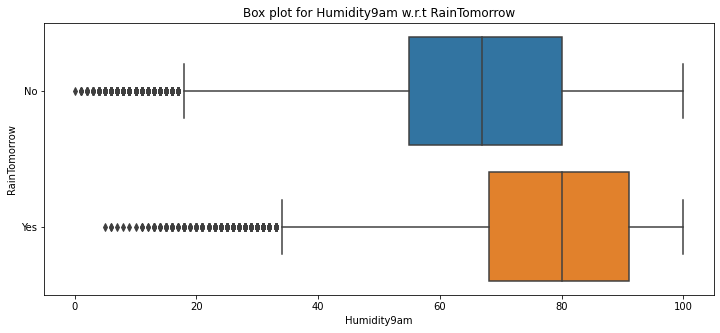

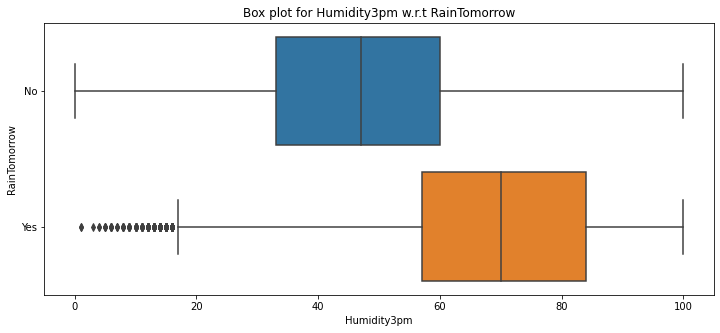

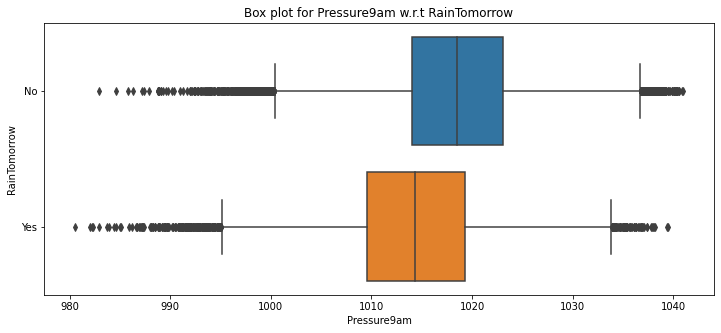

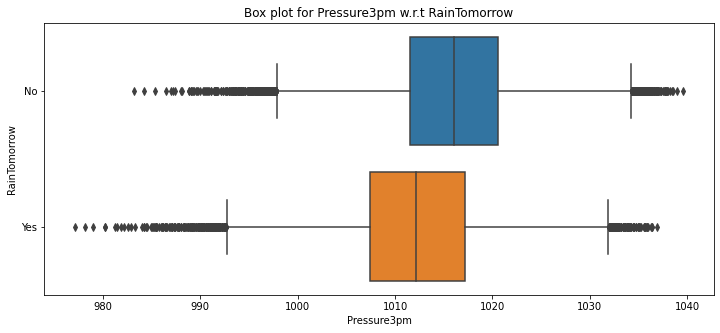

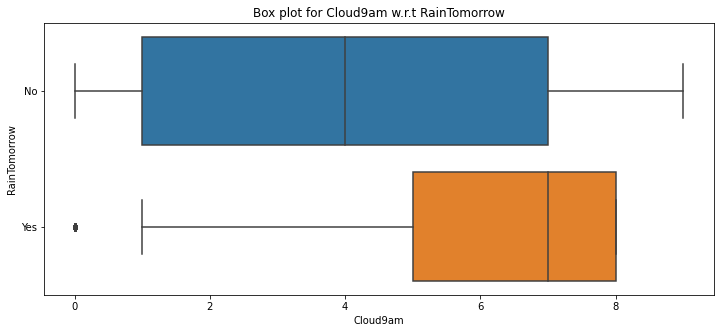

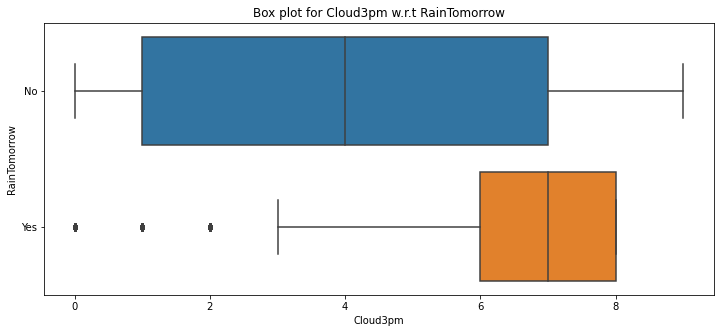

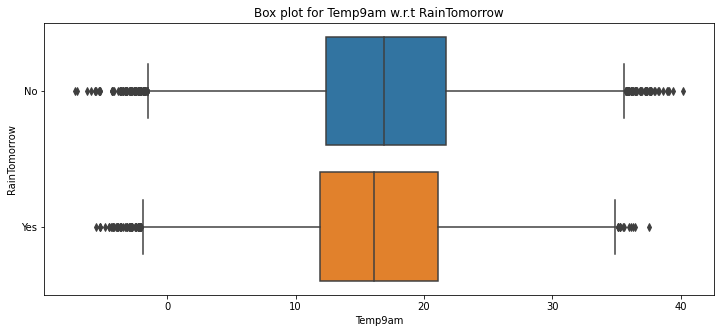

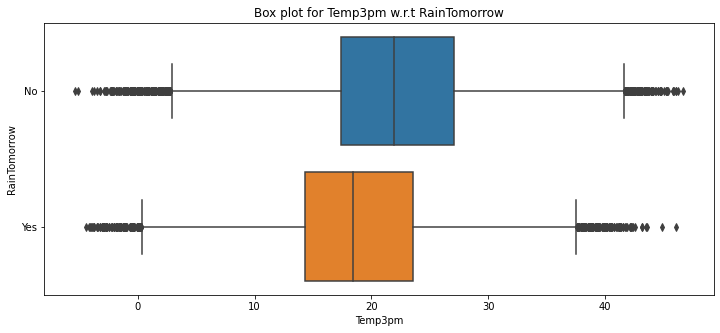

In [12]:
for col in cont_cols:
    fig = plt.figure(figsize=(12, 5))
    ax = fig.gca()
    plt.title(f"Box plot for {col} w.r.t RainTomorrow")
    sns.boxplot( x = col, y = 'RainTomorrow', data=dataset, ax = ax);

### Correlation Analysis

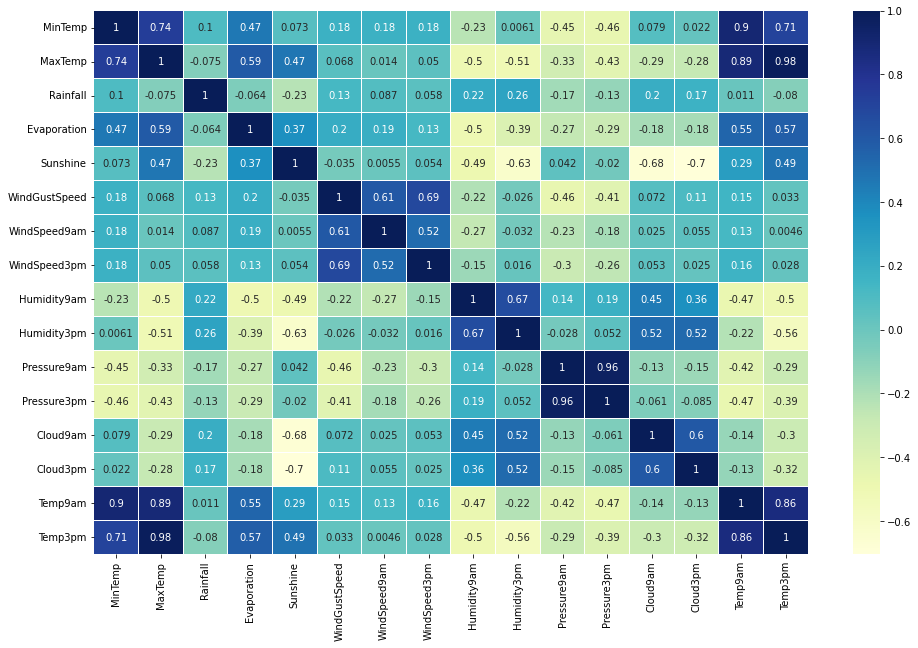

In [13]:
fig = plt.figure(figsize=(16, 10));
sns.heatmap(dataset[cont_cols].corr(), cmap="YlGnBu",  annot=True, linewidths ='.02');

## Data Pre-processing and cleaning

In [14]:
# Creating a copy of dataset
data_raw = dataset.copy()

### Checking for Missing Values

In [15]:
null_volumetric = check_missingValue(dataset)
null_volumetric.sort_values(by = '%Missing value', ascending=False)

,Column,Missing value,%Missing value
6,Sunshine,69835,48.01
5,Evaporation,62790,43.17
18,Cloud3pm,59358,40.81
17,Cloud9am,55888,38.42
15,Pressure9am,15065,10.36
16,Pressure3pm,15028,10.33
9,WindDir9am,10566,7.26
7,WindGustDir,10326,7.10
8,WindGustSpeed,10263,7.06
14,Humidity3pm,4507,3.10


### Missing Value Treatment

- <b>Dropping rows where target "RainTomorrow" is null</b>

In [16]:
data_tw = data_raw.dropna(subset = ["RainTomorrow"])
print("Shape of the data after droping missing value present in RainTomorrow")
print(data_tw.shape)

Shape of the data after droping missing value present in RainTomorrow
(142193, 23)


- <b>Dropping columns where "%Missing Value" is more than ~40%* because imputing may add unwanted bias in the data</b>

In [17]:
cols_to_drop = ['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm']
data_tw = data_raw.drop(columns = cols_to_drop)

print(f"Shape of the data after droping missing value present in {cols_to_drop}")
print(data_tw.shape)

Shape of the data after droping missing value present in ['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm']
(145460, 19)


- <b>Imputing the missing values</b>

In [18]:
imputer = SimpleImputer(strategy="most_frequent")
imputed_array = imputer.fit_transform(data_tw)

data_tw_imputed = pd.DataFrame(imputed_array, columns=data_tw.columns)

print(f"Shape of the data after imputing missing values")
print(data_tw_imputed.shape)

Shape of the data after imputing missing values
(145460, 19)


Missing value imputation post check

In [19]:
null_volumetric = check_missingValue(data_tw_imputed)
null_volumetric.sort_values(by = '%Missing value', ascending=False)

,Column,Missing value,%Missing value
0,Date,0,0.0
10,WindSpeed3pm,0,0.0
17,RainToday,0,0.0
16,Temp3pm,0,0.0
15,Temp9am,0,0.0
14,Pressure3pm,0,0.0
13,Pressure9am,0,0.0
12,Humidity3pm,0,0.0
11,Humidity9am,0,0.0
9,WindSpeed9am,0,0.0


### Extracting Year, Month, Week, Day of the week from "Date"

In [20]:
data_tw_imputed["Date"] = pd.to_datetime(data_tw_imputed["Date"])

data_tw_imputed['Year'] = data_tw_imputed["Date"].dt.year.astype(object)
data_tw_imputed['Month'] = data_tw_imputed["Date"].dt.month.astype(object)
data_tw_imputed['Week'] = data_tw_imputed["Date"].dt.week.astype(object)
data_tw_imputed['dayofweek'] = data_tw_imputed["Date"].dt.dayofweek.astype(object)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


In [21]:
# Getting the feature list 

target = 'RainTomorrow'
cont_cols2 = list(set(cont_cols) - set(cols_to_drop) - set([target]))
cat_cols2 = list(set(cat_cols) - set(cols_to_drop) - set([target, 'Date'])) + ['Year', 'Month', 'Week', 'dayofweek']

for col in cont_cols2:
    data_tw_imputed[col] = data_tw_imputed[col].astype(float)

for col in cat_cols2:
    data_tw_imputed[col] = data_tw_imputed[col].astype(object)
    
print("Features after missing value treatment:\n")
print(f"Target: {target}")
print()
print(f"Continuos Features: {cont_cols2}")
print()
print(f"Categorical Features: {cat_cols2}")

Features after missing value treatment:

Target: RainTomorrow

Continuos Features: ['Temp3pm', 'Temp9am', 'MinTemp', 'Pressure9am', 'WindSpeed3pm', 'Rainfall', 'WindSpeed9am', 'Pressure3pm', 'Humidity9am', 'WindGustSpeed', 'Humidity3pm', 'MaxTemp']

Categorical Features: ['RainToday', 'WindGustDir', 'WindDir3pm', 'WindDir9am', 'Location', 'Year', 'Month', 'Week', 'dayofweek']


In [22]:
# Creating a copy of imputed dataset for quick rollback
data_tw_level2 = data_tw_imputed.copy()

### Label Encoding the Target Variable "RainTomorrow"

In [23]:
target_en = LabelEncoder()
data_tw_level2[target] = target_en.fit_transform(data_tw_level2[target])

In [24]:
get_volumetric(data_tw_level2, target)

,RainTomorrow,volume,%volume
0,0,113583,78.09
1,1,31877,21.91


### Standardizing &  Correcting the skewness of Continous Features by applying log transformation

In [25]:
for col in cont_cols2:
    print(f"Applying log Transformation {col}")
    data_tw_level2[col] = data_tw_level2[col].apply(lambda x: np.log2(x+0.001))

Applying log Transformation Temp3pm
Applying log Transformation Temp9am
Applying log Transformation MinTemp
Applying log Transformation Pressure9am
Applying log Transformation WindSpeed3pm
Applying log Transformation Rainfall
Applying log Transformation WindSpeed9am
Applying log Transformation Pressure3pm
Applying log Transformation Humidity9am
Applying log Transformation WindGustSpeed
Applying log Transformation Humidity3pm
Applying log Transformation MaxTemp


### Applying One-hot Encoding on Categorical Features

In [26]:
data_tw_level2 = pd.get_dummies(data_tw_level2, columns=cat_cols2, drop_first=True)

In [27]:
print("Shape of the dataset after encoding:", data_tw_level2.shape)

Shape of the dataset after encoding: (145460, 187)


## Data Preparation

In [28]:
feature_list = set(data_tw_level2.columns) - set([target, 'Date'])

X = data_tw_level2[feature_list].astype(float)
y = data_tw_level2[target].values

print(f"Dataset Shape:\n\nX -> {X.shape}\ny -> {y.shape}")

# Applying PCA to reduce the dimensions and sparsity
pca = PCA(n_components=32)
X_reduced = pca.fit_transform(X.fillna(0.0))

# Keeping 20% of the data aside for testing
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size = .20, random_state=2020)

print(f"\nTrain-Test Shape:\n \nX_train -> {X_train.shape} \t y_train -> {y_train.shape} \nX_test ->  {X_test.shape} \t y_test -> {y_test.shape}")

Dataset Shape:

X -> (145460, 185)
y -> (145460,)

Train-Test Shape:
 
X_train -> (116368, 32) 	 y_train -> (116368,) 
X_test ->  (29092, 32) 	 y_test -> (29092,)


## Model Building

In [29]:
# Initialising the ANN

leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.3)

model = Sequential()
model.add(Dense(units = 32, activation = leaky_relu, input_dim = 32))
model.add(Dense(units = 32, activation = leaky_relu))
model.add(Dense(units = 16, activation = leaky_relu))
model.add(Dense(units = 8,  activation = leaky_relu))
model.add(Dense(units = 1, activation = 'sigmoid'))

print("ANN Model Summary:")
model.summary()
print()

# Compiling the ANN
adam = Adam(learning_rate=0.00001)
model.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Training the ANN
history = model.fit(X_train,
                    y_train, 
                    batch_size = 128, 
                    epochs = 100, 
                    validation_split=0.2)

ANN Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,785
Trainable params: 2,785
Non-trainable params: 0
_________________________________________________________________

Epoch 1/100
728/728 [=============

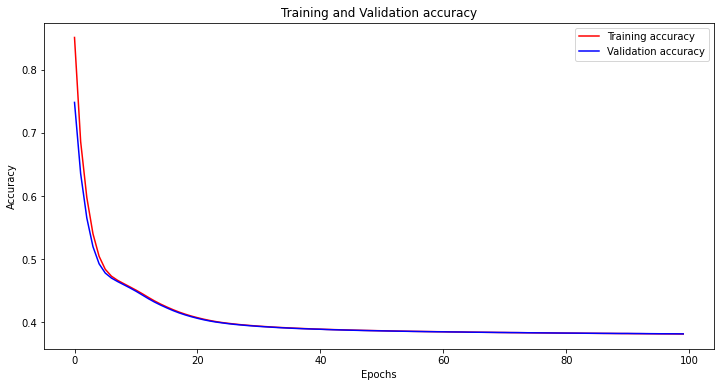

In [34]:
history_df = pd.DataFrame(history.history)

plt.figure(figsize= (12,6))
plt.plot(history_df.loc[:, ['accuracy']], color="red", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], color="blue", label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

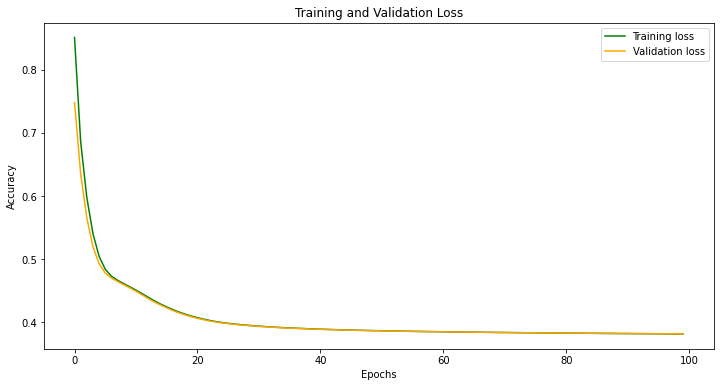

In [36]:
history_df = pd.DataFrame(history.history)

plt.figure(figsize= (12,6))
plt.plot(history_df.loc[:, ['loss']], color="green", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']], color="orange", label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Predicting the test set results

In [37]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

In [38]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.95      0.90     22612
           1       0.70      0.42      0.53      6480

    accuracy                           0.83     29092
   macro avg       0.78      0.69      0.71     29092
weighted avg       0.82      0.83      0.82     29092



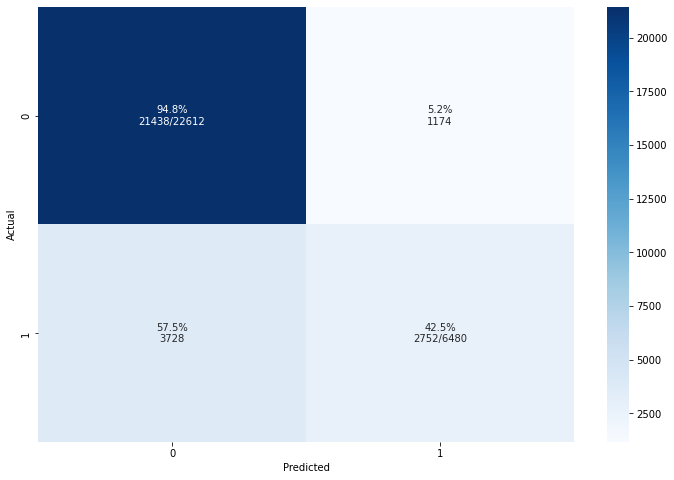

In [39]:
# Confusion Matrix
plot_cm(y_test, y_pred, figsize=(12,8))